# Vehicle detection


#### Imports

In [28]:
from keras.models import load_model
import cv2
import csv
import glob
import numpy as np
from keras.models import Model, Sequential
from keras.layers.core import Dropout
from keras.layers import Input, Flatten, Dense, Lambda, Cropping2D, Convolution2D, BatchNormalization, MaxPooling2D
from sklearn.model_selection import  train_test_split
from sklearn.utils import  shuffle
import matplotlib.pyplot as plt
import random
from scipy.ndimage.measurements import label
import skimage

%matplotlib inline

#### Data preparation

In [29]:
def save_as_sample(inp, out, xmin, ymin, xmax, ymax, label):
    # Read the file
    img = cv2.imread(inp)

    # Crop to the region of interest
    img = img[ymin:ymax, xmin:xmax]

    # Resize to a desired dimension
    img = cv2.resize(img, (64, 64))

    # Find the category
    if label == 'pedestrian' or label == 'trafficLight':
        category = 'non-vehicles'
    else:
        category = 'vehicles'

    # Write the image to disk
    cv2.imwrite('data/additional/{0}/{1}'.format(category, out), img)


def build_additional_samples(path, input_idx):    
    with open('{}/labels.csv'.format(path)) as log_file:
        # Read the csv file
        reader = csv.reader(log_file)
        
        idx = 0
        if input_idx == 0:
            idx = 1
    
        # Read all the lines from csv file
        for line in tqdm(reader):     
            if len(line) == 1:
                log = line[0].split(' ')
            else:
                log = line
            
            xmin = int(log[0 + idx])
            ymin = int(log[1 + idx])        
            xmax = int(log[2 + idx])
            ymax = int(log[3 + idx])
            inp = '{0}/{1}'.format(path, log[input_idx])
            label = log[5 + idx].lower().replace('"', '')
            out = log[0 + idx] + log[1 + idx] + log[2 + idx] + log[3 + idx] + '_' + log[input_idx]

            save_as_sample(inp, out, xmin, ymin, xmax, ymax, label)

# Start building additional samples (Uncomment below lines to generate)
# build_additional_samples('data/object-dataset', 0)
# build_additional_samples('data/object-detection-crowdai', 4)

def read_image(path):
    return np.array(cv2.imread(path))


### Data Exploration

In [30]:
# Get the count from files
num_vehicles = len(glob.glob('data/vehicles/*/*.png'))
num_vehicles_add = len(glob.glob('data/additional/vehicles/*.jpg'))
num_non_vehicles = len(glob.glob('data/non-vehicles/*/*.png'))
num_non_vehicles_add = len(glob.glob('data/additional/non-vehicles/*.jpg'))

# After data augmentation
total = num_vehicles + num_non_vehicles
total_aug = (num_non_vehicles + num_non_vehicles_add + num_vehicles + num_vehicles_add) * 2

# Print the statistics
print("Number of vehicles examples before data augmentation =", num_vehicles)
print("Number of additional vehicles examples =", num_vehicles_add)
print("Number of non-vehicles examples =", num_non_vehicles)
print("Number of additional non-vehicles examples =", num_non_vehicles_add)

print("Total data available before augmentation =", total)
print("Total data available after augmentation =", total_aug)


Number of vehicles examples before data augmentation = 8792
Number of additional vehicles examples = 68972
Number of non-vehicles examples = 8968
Number of additional non-vehicles examples = 27186
Total data available before augmentation = 17760
Total data available after augmentation = 227836


### Training

In [31]:
class HyperParameters:
    def __init__(self, epochs=18, batch_size=64, dropout=0.5):
        self.epochs = epochs
        self.batch_size = batch_size
        self.dropout = dropout
        
        # Other parameters
        self.input_shape = None

def extract_samples():
    # Get paths to all the images
    vehicles = glob.glob('data/vehicles/*/*.png') #+ glob.glob('data/additional/vehicles/*.jpg')
    non_vehicles = glob.glob('data/non-vehicles/*/*.png') #+ glob.glob('data/additional/non-vehicles/*.jpg')   
    
    # Concatenate them
    samples = vehicles + non_vehicles

    return train_test_split(samples, test_size=0.1, random_state=42)

def batch_generator(samples, batch_size):
    num_samples = len(samples)

    while 1:
        shuffle(samples)

        for offset in range(0, num_samples, batch_size):
            end = offset + batch_size
            batch_samples = samples[offset:end]

            images = []
            labels = []

            for batch_sample in batch_samples:                
                # Get the image
                image = read_image(batch_sample)
                
                # Data augmentation through flipping
#                 flipped = np.fliplr(image)
                
                # Check if this sample is a vehicle(1)
                label = int(not('non-vehicles' in batch_sample))
                
                # Add all the data to the batch            
#                 images.extend([image, flipped])
#                 labels.extend([label, label])
                images.extend([image])
                labels.extend([label])
                
            X_train = np.array(images)
            y_train = np.array(labels)
                
            # Shuffling again so to overcome the repeat due to data augmentation
            yield shuffle(X_train, y_train)
            
def get_training_data():
    cars = glob.glob("data/vehicles/*/*.png")
    non_cars = glob.glob("data/non-vehicles/*/*.png")

    # Read X Vector
    X = []
    for file in cars:    
        X.append(read_image(file))
    for file in non_cars:    
        X.append(read_image(file))
    X = np.array(X)

    # Generate Y Vector
    Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))])

    # Split train and validation dataset with 10%
    return train_test_split(X, Y, test_size=0.1, random_state=63)


def show_plot(history_object):    
    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

def build_model(hp, flatten=False):
    # Input
    inp = Input(hp.input_shape)
    
    # Normalization
    out = Lambda(lambda x: x/127.5 - 1.0)(inp)
    
    # Convolution + Dropout
    out = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(out)
    out = Dropout(hp.dropout)(out)
    
    # Convolution + Dropout
    out = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(out)
    out = Dropout(hp.dropout)(out)
    
    # Convolution + MaxPooling + Dropout
    out = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(out)
    out = MaxPooling2D(pool_size=(8, 8))(out)
    out = Dropout(hp.dropout)(out)
    
    # Convolution + Dropout
    out = Convolution2D(64, 8, 8, activation='relu')(out)
    out = Dropout(hp.dropout)(out)
    
    # Convolution
    out = Convolution2D(1, 1, 1, activation='tanh')(out)
    
    # Only during training time
    if flatten:
        # Flatten
        out = Flatten(name="flatten")(out)
    
    # Create the model
    model = Model(inp, out)
    
    return model
    
    
def train():
    # Step 0: Init hyper-parameters
    hp = HyperParameters()

    # Step 1 : Extracting the required data
    samples_train, samples_valid = extract_samples()
    gen_train = batch_generator(samples_train, hp.batch_size)
    gen_valid = batch_generator(samples_valid, hp.batch_size)

    # Step 2: Set other Hyper-parameters    
    hp.input_shape = read_image(samples_train[0]).shape
    num_samples = len(samples_train) #* 2
    
    # Step 3 : Train the model
    model = build_model(hp, True)    
    model.summary()
           
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])    
    history_object = model.fit_generator(gen_train,
                                        nb_epoch=hp.epochs,
                                        samples_per_epoch=num_samples,
                                        nb_val_samples=num_samples,
                                        validation_data=gen_valid,
                                        verbose=1)
    
    # Display some metrics
    show_plot(history_object)
    
    # Preserve the weights
    model.save_weights('model.h5')
    
        

In [32]:
train()

### Testing the model on samples

In [33]:
# Get the model ready
hp = HyperParameters()
hp.input_shape = (64, 64, 3)
hp.dropout = 1.0

model = build_model(hp)
model.load_weights('model.h5')
print('Model ready!')

Model ready!


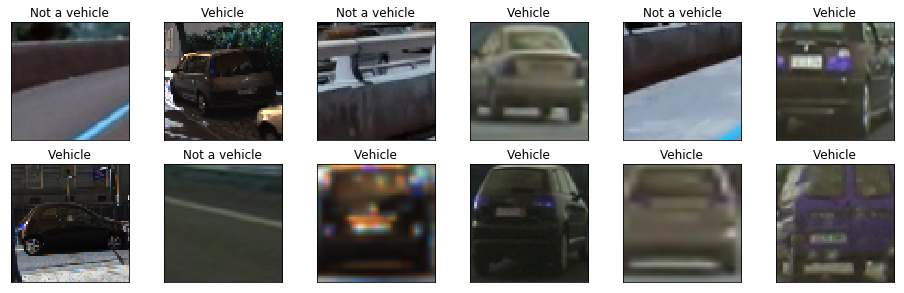

In [34]:

def predict_on_samples(count=12):
    samples = glob.glob('data/vehicles/*/*.png') + glob.glob('data/non-vehicles/*/*.png')
    
    fig = plt.figure(figsize=(16, 10))
    
    for idx in range(count):
        # Get a random sample and check
        path = samples[random.randint(0, len(samples))]
        img = cv2.imread(path)
        
        # Do prediction
        sample = np.reshape(img, (1,) + img.shape)
        prediction = model.predict(sample)
        
        if prediction > 0.5:
            pred_txt = 'Vehicle'
        else:
            pred_txt = 'Not a vehicle'
        
        ax = fig.add_subplot(4, 6, idx + 1)
        ax.set_title(pred_txt)
        ax.imshow(img)
        
        # Hide the axes
        ax.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

        
    plt.show()

predict_on_samples(12)

### Pipeline

In [46]:
# Utility function to draw bounding boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:                
        top = bbox[0]
        bottom = bbox[1]        
        
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, top, bottom, color, thick)
        
    # Return the image copy with boxes drawn
    return imcopy

# Funciton that returns the list of boxes that has a detected vehicle
def detect_vehicles(img):                                          
    # Region definitions
    img_ht, img_wt, _ = img.shape
    x_start = img_wt//2
    x_stop = img_wt
    y_start = img_ht//2 - 40
    y_stop = img_ht - 90
    
    # Clip the image to this region
    clip = np.copy(img)[y_start:y_stop, x_start:x_stop]
            
    # Reshape it for the model
    inp = clip.reshape((1, ) + clip.shape)
    
    # load the model
    hp = HyperParameters()
    hp.input_shape = clip.shape
    hp.dropout = 1.0
    model = build_model(hp)
    model.load_weights('model.h5')
    
    # find the vehicles through activations from the last layer
    activations = model.predict(inp)
    
    # This finds us rectangles that are interesting
    xx, yy = np.meshgrid(np.arange(activations.shape[2]), np.arange(activations.shape[1]))
    x = (xx[activations[0,:,:,0] > ACTIVATION_THRESHOLD])
    y = (yy[activations[0,:,:,0] > ACTIVATION_THRESHOLD])
    
    # Initialize the bounding boxes
    bboxes = []
    # We save those rects in a list
    for i, j in zip(x,y):
        bboxes.append(((x_start + i*8, y_start + j*8), (x_start + i*8 + 64, y_start + j*8 + 64)))
                  
    return bboxes


def add_heat(img, bbox_list):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

# The pipeline
ACTIVATION_THRESHOLD = 0.7
def process(img):    
    # Find the areas on the image where vehicle detections are activated
    bboxes = detect_vehicles(img)   
            
    # Visualize the bounding boxes
    #out = draw_boxes(img, bboxes, color=(0, 255, 0), thick=2)

    # Build up heatmap
    heat = add_heat(img, bboxes)
    
    # Apply threshold to eliminate false positives
    heat = apply_threshold(heat, 3)
    
    # Visualize the heatmap 
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    out = draw_labeled_bboxes(np.copy(img), labels)
            
    return out



In [47]:
# Test it on samples
def predict_on_test_images(test_images, count = 4):    
    fig = plt.figure(figsize=(16, 10))

    # for image in test_images:    
    for idx in range(count):
        # Get a random sample and check
        path = test_images[random.randint(0, len(test_images) - 1)]        
        image = np.array(cv2.imread(path))

        out_img = process(image)

        # To correct color representation between cv2 and matplotlib
        out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

        ax = fig.add_subplot(2, 2, idx + 1)
        ax.set_title(path)
        ax.imshow(out_img)

        # Hide the axes
        ax.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    
    


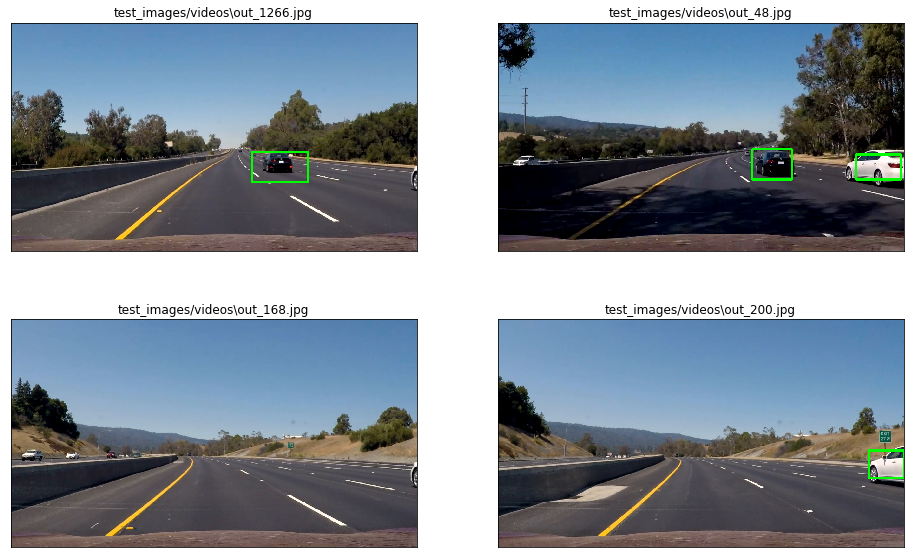

In [48]:
test_images = glob.glob('test_images/videos/*.jpg')
predict_on_test_images(test_images, 4)

### Video

In [49]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import HTML
import matplotlib
from tqdm import tqdm

def save_image(img):
    path = 'output_videos/staging-1/{}.jpg'

    files = glob.glob(path.format('*'))
    count = len(files)

    # Set the file name
    out = path.format(count)

    # Save the image
    matplotlib.image.imsave(out, img)
        
    return img

def process_images_from_staging():    
    path = 'output_videos/staging-{0}/{1}.jpg'

    files = glob.glob(path.format(1, '*'))
    end = len(files) - 1
        
    start = len(glob.glob(path.format(2, '*')))

    for idx in tqdm(range(start, end)):
        src = path.format(1, idx)
        des = path.format(2, idx)
                                
        # Process through pipeline
        img = process(cv2.imread(src))

        # To correct color representation between cv2 and matplotlib
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Save the processed image
        matplotlib.image.imsave(des, img)
        
def video_from_staging():
    # Destination where the output video will get saved
    OUTPUT = 'output_videos/output.mp4'
    
    path = 'output_videos/staging-2/{}.jpg'

    files = glob.glob(path.format('*'))
    count = len(files) - 1

    
    images_list = []
    for idx in tqdm(range(count)): 
        src = path.format(idx)                    
        images_list.append(src)
        
    
    clip = ImageSequenceClip(images_list, fps=30)
    
    
    # Write it as output
    %time clip.write_videofile(OUTPUT, audio=False)



### Testing out the videos by stages

In [50]:
save_image()

process_images_from_staging()

video_from_staging()

In [51]:
# Destination where the output video will get saved
OUTPUT = 'output_videos/output.mp4'

# Get the clip from input video
clip = VideoFileClip('project_video.mp4') #.subclip(40, 41)
# clip = VideoFileClip('test_video.mp4')

# Process the clip
# processed_clip = clip.fl_image(process)
processed_clip = clip.fl_image(save_image)

# Write it as output
%time processed_clip.write_videofile(OUTPUT, audio=False)

In [25]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(OUTPUT))